# Pygenlib 

Pygenlib is a python utilities library for handling genomics data.
It is roughly structured into the following modules:

- [iterators](#Iterators): efficient iteration over large-scaled genomics datasets. Iterators keep track of the genomic region of the
  yielded data enabling their efficient integration with other genomics data
- [genemodel](#Transcriptome): python classes for modeling genomics (annotation) data. This includes a '[transcriptome](#Transcriptome)' implementation 
  that models gene/transcript annotations and many useful querying/annotation methods.
- [utils](#Utility-functions): general (low-level) utility functions for working with genomics datasets.


In [1]:
# set path and install missing libraries
import os, pathlib
from platform import python_version
PYGENLIB_SRC=pathlib.Path().cwd().parent #'/groups/ameres/Niko/workspace/pygenlib/' # '/Users/niko.popitsch/git/pygenlib/' 
os.chdir(PYGENLIB_SRC)
# install libraries. better to use a venv here!
#!python -m pip install -r requirements.txt 
display(f"Running pygenlib on python {python_version()}. Using pygenlib code from {PYGENLIB_SRC}")

'Running pygenlib on python 3.9.12. Using pygenlib code from /groups/ameres/Niko/workspace/pygenlib'

In [2]:
# load libs
from IPython.display import Markdown
from Bio.Seq import Seq
import matplotlib.pyplot as plt
from pygenlib.utils import *
from pygenlib.iterators import *
from pygenlib.genemodel import *
import pprint
import numpy as np
import pandas as pd
import pprint
SEP=Markdown('---')
!pwd

/groups/ameres/Niko/workspace/pygenlib


## Genomic intervals
Genomic regions are referenced by *genomic intervals* (gi) in pygenlib:
- Genomic intervals (gi) in pygenlib are inclusive and 1-based. 
- GIs are implemented as frozen (pseudo immutable) dataclasses and can thus be used, e.g., as keys in a dict.
- GIs can be instantiated by passing chrom/start/stop coordinates or can be parsed form a string. 
- GIs can be stranded. Unstranded intervals are represented by setting strand to None (default) 
- Using None for each component of the coordinates is allowed to represent unbounded intervals. Examples:
  - gi('chr1') refers to the whole chromosome
  - gi('chr1', 100000) refers to the section of chromosome 1 from (and including) positon 100k on.
  - gi(start=100, end=200) refers to positions 100-200 (inclusive) on any chromosome 
- Points are represented by GIs with same start and end coordinate.
- Empty intervals are represented by GIs with start>end coordinates (experimental)

Chromosome order in a genome is represented by *ReferenceDict*s (which extend regular python dicts).
- ReferenceDicts can be used to properly sort genomic intervals (see example below)
- ReferenceDicts keep track of the available chromosomes and their length and are typically directly derived from genomic data files
- ReferenceDicts are used in pygenlib to check for compatibility of different genomic datasets

In [3]:
# create a list of genomic intervals
locs=[gi('chr2', 1, 100), # chr2:1-100, unstranded
      gi.from_str('chr1:5-500 (+)'),  # parsed from string, strand='+'
      gi.from_str('chr3:50-120 (-)'), 
      gi.from_str('chr1:10-20 (-)'), 
      gi(None, None, 1000, '-'), # chromosome and start unbound, end=1000, strand='-'
      gi(None, 10, 1000, '-')] # chromosome unbound
display('Sorted by start coordinate but order of chromosomes is undefined:', sorted(locs), SEP)

# Note that chromosome group intervals and the order of intervals from different groups (chromosomes) is left undefined.
display(f"Is the greater-than comparison chr2:1-1>chr1:1-1 defined? {gi('chr2', 1, 1) > gi('chr1', 1, 1)}", SEP)

# To sort also by chromosome, you can use a reference dict which defined the chromosome order:
refdict=ReferenceDict({'chr1':None, 'chr2':None, 'chr3':None}, 'test', None)
display(refdict, SEP)
display('Properly sorted list:', sorted(locs, key=lambda x: (refdict.index(x.chromosome), x)))
# Unbounded intervals (chromosome=None) will always be at the beginning of the list

'Sorted by start coordinate but order of chromosomes is undefined:'

[None:-inf-1000 (-),
 chr2:1-100,
 chr1:5-500 (+),
 chr3:50-120 (-),
 chr1:10-20 (-),
 None:10-1000 (-)]

---

'Is the greater-than comparison chr2:1-1>chr1:1-1 defined? None'

---

Refset (size: 3): dict_keys(['chr1', 'chr2', 'chr3']), dict_values([None, None, None]) name: test 

---

'Properly sorted list:'

[None:-inf-1000 (-),
 None:10-1000 (-),
 chr1:5-500 (+),
 chr1:10-20 (-),
 chr2:1-100,
 chr3:50-120 (-)]

# Iterators

_pygenlib_ implements several *LocationIterator*s for efficient iteration over (parts of) genomics datasets while keeping track of the [genomic interval](#Genomic-intervals) each yielded item refers to. Most implemented iterators are based on respective [pysam](https://pysam.readthedocs.io/en/latest/api.html) classes but extend them with different filtering/access methods and add sanity checks to avoid common errors when combining different genomics datasets.

The primary goal of LocationIterators is to support the synchronization/integration of different genomics datasets. LocationIterators also support chunked I/O where feasible and not supported by the underlying (pysam) implementation.

LocationIterators can iterate whole datasets or specific sub-region (e.g., a certain chromosome or genomic region). Yielded data items are sorted by respective [genomic intervals](#Genomic-intervals) where the order of chromosomes is defined by a [ReferenceDict](#Genomic-intervals) that is derived directly from the iterated dataset (e.g., by querying it's tabix index). When multiple LocationIterators are integrated (e.g., by an AnnotationIterator), their ReferenceDicts are checked for compatibility.

Sometimes, genomics datasets from different providers used differing chromosome ids to refer to the same chromosomes which hinders their integration. 
Location iterators support chromosome aliasing as a quick solution for this: users can provide aliasing functions (e.g., for adding/removing 'chr' prefixes from 
chromosome ids) to dynamically change chromosome ids while keeping the underlying data files untouched.

Implemented LocationIterators include:
* [FastaIterator](#FastaIterator): iterates FASTA files per position or genomic window (e.g., Tiling/sliding windows).
* [GFF3Iterator](#GFF3Iterator): iterates GTF/GFF3 files and parses annotation data. Used for the [Transcriptome](#transcriptome) implementation
* [ReadIterator](#ReadIterator): iterates SAM/BAM files and implements various filter options. 
* [VcfIterator](#AnnotationIterator): iterates VCF files and can filter for samples
* [AnnotationIterator](#AnnotationIterator): annotates the items from one LocationIterator with items from others

and many more.
The following sections showcase some of the implemented iterators:

## FastaIterator
Iterates over a FASTA file but enables also tiling/sliding windows and padding.

In [4]:
# FastaIterator that supports window/step size and padding
fasta_file='testdata/ACTB+SOX2.fa.gz'

# get 5mer sliding windows (step size 2) with padding from a GRCh38 chr7 region around ACTB; show first and last 5 results
# <it>.take() consumes the whole iterator and stores the items in a list.
# item.data returns the data item returned by this iterator (here: a string containing the kmer)
# item.location is a GI describing the genomic location of this sequence
kmers=[item.data for item in FastaIterator(fasta_file, 'chr7', None, None, width=5, step=2, padding=True).take()]
display(f"{kmers[:5]}...{kmers[-5:]}")

"['NNTTG', 'TTGTG', 'GTGCC', 'GCCAT', 'CATTA']...['TTGTA', 'GTATT', 'ATTTT', 'TTTTN', 'TTNNN']"

## GFF3Iterator
Iterates over GFF3 files and yields dicts containing parsed annotation fields.

In [5]:
# Show some data from a GFF3 file
GFF3Iterator('testdata/gencode.v39.ACTB+SOX2.gff3.gz').take()[:10]

# iterate whole GFF3 file and collect stats of contained feature_type annotations
Counter([item.data['feature_type'] for item in GFF3Iterator('testdata/gencode.v39.ACTB+SOX2.gff3.gz')])

Counter({'gene': 2,
         'transcript': 24,
         'exon': 106,
         'five_prime_UTR': 33,
         'start_codon': 17,
         'CDS': 60,
         'stop_codon': 13,
         'three_prime_UTR': 20})

## ReadIterator
Iterates SAM/BAM files and implements several filter options. Also keeps track of how many reads were filtered for what reason.
Can also yield mismatches wrt. the reference if MD tags are available (can be added, e.g., by [samtools calmd](http://www.htslib.org/doc/samtools-calmd.html) if not added by the mapper itself).


In [6]:
# count reads per chromosome in a BAM using different filters
stats={x:Counter() for x in ['all', 'def', 'mq20', 'tag']}
with open_file_obj('testdata/small_example.bam') as bam:
    for chrom in get_reference_dict(bam):
        with ReadIterator(bam, chrom, flag_filter=0) as it: # all: no filtering
            it.take()
            stats['all'].update(it.stats)
        with ReadIterator(bam, chrom) as it: # def: default flag filter (as in IGV)
            it.take()
            stats['def'].update(it.stats)
        with ReadIterator(bam, chrom, min_mapping_quality=20) as it: # mq20: default flag filter, mapping quality >= 20
            it.take()
            stats['mq20'].update(it.stats)
        with ReadIterator(bam, chrom, tag_filters=[TagFilter('MD', ['100'])]) as it: # tag: default flag filter, MD tag must be '100'
            it.take()
            stats['tag'].update(it.stats)
display(stats)

{'all': Counter({('n_reads', '1'): 31678}),
 'def': Counter({('n_reads', '1'): 21932, ('n_fil_flag', '1'): 9746}),
 'mq20': Counter({('n_reads', '1'): 21626,
          ('n_fil_flag', '1'): 9746,
          ('n_fil_mq', '1'): 306}),
 'tag': Counter({('n_fil_tag', '1'): 14544,
          ('n_fil_flag', '1'): 9746,
          ('n_reads', '1'): 7388})}

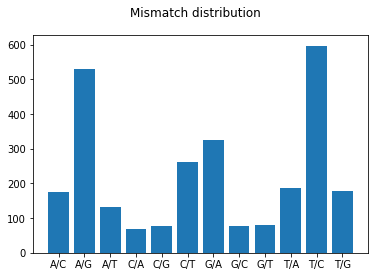

In [7]:
# Calculate mismatch profile and plot. 
# - iterate over alignment and report mismatches, so returned item.data is a tuple (read, mismatches)
# - ref/alt alleles are revcomped if read is reversed (strand specific)
# - count and plot results
profile=Counter()
for l,(r,mm) in ReadIterator('testdata/small_example.bam',report_mismatches=True, min_base_quality=10):
    is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
    for (readpos, genpos, ref, alt) in mm:
        if is_rev: # correct for read strand
            ref,alt=reverse_complement(ref),reverse_complement(alt)
        profile[f"{ref}/{alt}"]+=1
# plot the data
labels, values = zip(*sorted(profile.items()))
plt.bar(range(len(labels)), values, 0.8)
plt.xticks(range(len(labels)), labels)
plt.suptitle("Mismatch distribution")
plt.show()

In [8]:
# Count T/C (A/G) mismatches per chromosome.
bam_file='testdata/small_example.bam'
profile=Counter()
for l,(r,mm) in tqdm(ReadIterator(bam_file,report_mismatches=True, min_base_quality=10), total=sum([x.total for x in open_file_obj(bam_file).get_index_statistics()])):
    is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
    refc = "A" if is_rev else "T"
    altc = "G" if is_rev else "C"
    for (readpos, genpos, ref, alt) in mm:
        n_ref = r.query_sequence.count(refc)
        mm_tc=[(off, pos1, ref, alt) for off, pos1, ref, alt in mm if ref==refc and alt==altc]
        profile[r.reference_name,refc,altc,n_ref,len(mm_tc)]+=1
# filter for min number of counts
profile=pd.DataFrame([list(k)+[v] for k,v in profile.items()], columns=['chromosome','ref','alt', 'convertible','converted', 'count'])
profile=profile[profile['count']>10]

# show filtered data, grouped by strand and convertible positions
fil=profile.query('20 <= convertible <= 25').sort_values(['convertible', 'converted'])
fil['conv']=fil['ref']+"/"+fil['alt']
grouped=fil.groupby(['conv', 'convertible'])
for i, key in enumerate(grouped.groups.keys()):
    dat=grouped.get_group(key).set_index('conv')
    print(dat)

 69%|██████▉   | 21932/31678 [00:00<00:00, 48667.35it/s]

     chromosome ref alt  convertible  converted  count
conv                                                  
A/G           1   A   G           20          0     41
     chromosome ref alt  convertible  converted  count
conv                                                  
A/G           1   A   G           21          0     37
     chromosome ref alt  convertible  converted  count
conv                                                  
A/G           1   A   G           22          0     48
A/G           1   A   G           22          1     11
     chromosome ref alt  convertible  converted  count
conv                                                  
A/G           1   A   G           23          0     56
A/G           1   A   G           23          1     12
     chromosome ref alt  convertible  converted  count
conv                                                  
A/G           1   A   G           24          0     97
A/G           1   A   G           24          1     17
     chrom

In [9]:
# count t/c mismatches per read in a BAM file, filtering for minimum base quality
tc_conv={}
for l,(r,mm) in ReadIterator('testdata/small_example.bam',report_mismatches=True, min_base_quality=10):
#    if len(mm)>0: # at least 1 mismatch - just to speed things up.
        is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
        refc = "A" if is_rev else "T"
        altc = "G" if is_rev else "C"
        mm_tc=[(off, pos1, ref, alt) for off, pos1, ref, alt in mm if ref==refc and alt==altc] # get only T/C or A/G mismatches (depenging on read strand)
        if len(mm_tc) > 0: # at least 1 T/C or A/G mm
            tc_conv[r.query_name, not r.is_read2]=mm_tc

# show the first 10 reads
display('10 reads and their mismatches', {k:tc_conv[k] for k in list(tc_conv.keys())[:10]}, SEP)

# count reads with more than one T/C conversion
display('Number of reads with ore than one T/C conversion', len({k:tc_conv[k] for k in list(tc_conv.keys()) if len(tc_conv[k])>1}),SEP)

# show MM of one such read
display('Example read with 2 mismatches:', tc_conv['HWI-ST466_135068617:8:2316:4251:54002', False])

'10 reads and their mismatches'

{('HWI-ST466_135068617:8:1104:18372:89212', False): [(2, 22379204, 'A', 'G')],
 ('HWI-ST466_135068617:8:2114:8986:54547', False): [(98, 22404991, 'T', 'C')],
 ('HWI-ST466_135068617:8:2214:18036:44964', False): [(86, 22404981, 'A', 'G')],
 ('HWI-ST466_135068617:8:2301:15221:88708', True): [(71, 22404968, 'A', 'G')],
 ('HWI-ST466_135068617:8:1107:12866:40944', False): [(72, 22404971, 'A', 'G')],
 ('HWI-ST466_135068617:8:2101:20690:68324', False): [(78, 22404984, 'A', 'G')],
 ('HWI-ST466_135068617:8:1102:11736:16410', True): [(53, 22404966, 'T', 'C')],
 ('HWI-ST466_135068617:8:1103:20561:79535', True): [(52, 22404966, 'T', 'C')],
 ('HWI-ST466_135068617:8:2308:21226:40688', False): [(25, 22404940, 'A', 'G')],
 ('HWI-ST466_135068617:8:1303:15014:31681', False): [(2, 22379925, 'A', 'G')]}

---

'Number of reads with ore than one T/C conversion'

25

---

'Example read with 2 mismatches:'

[(2, 22443997, 'A', 'G'), (5, 22444000, 'A', 'G')]

## AnnotationIterator
Annotation iterators are meant to annotate the genomic intervals yielded by one location iterator with data from multiple others. 

In [10]:
# Iterate over annotations in a genomic subregion of the flybase GTF and 
# list the genotypes of annotated SNPs for 3 samples that overlap with those annotations

gff_file='testdata/flybase.dmel-all-r6.51.sorted.gtf.gz' 
vcf_file='testdata/dmelanogaster_6_exported_20230523.vcf.gz'

with AnnotationIterator(GFF3Iterator(gff_file, '2L', 574299, 575733), 
                        VcfIterator(vcf_file, samples=['DGRP-208', 'DGRP-325', 'DGRP-721'])) as it:
    for loc, (v1,v2) in it.take()[:5]:
        display(f"{loc} {v1} {v2}", SEP)

100%|██████████| 1/1 [00:00<00:00, 286.22it/s]


"2L:574291-574355 (+) {'gene_id': 'FBgn0031268', 'gene_symbol': 'cold', 'transcript_id': 'FBtr0310022', 'transcript_symbol': 'cold-RB', 'feature_type': '5UTR', 'source': 'FlyBase', 'score': None, 'phase': None} []"

---

"2L:574291-575734 (+) {'gene_id': 'FBgn0031268', 'gene_symbol': 'cold', 'feature_type': 'gene', 'source': 'FlyBase', 'score': None, 'phase': None} [Item(location=2L:574363-574363, data=2L:574363A>G), Item(location=2L:574391-574391, data=2L:574391T>C), Item(location=2L:574411-574411, data=2L:574411G>T), Item(location=2L:574422-574422, data=2L:574422T>A), Item(location=2L:574430-574430, data=2L:574430C>T), Item(location=2L:574501-574501, data=2L:574501C>A), Item(location=2L:574519-574519, data=2L:574519G>A), Item(location=2L:574708-574708, data=2L:574708A>G), Item(location=2L:574709-574709, data=2L:574709T>A), Item(location=2L:574820-574820, data=2L:574820C>T), Item(location=2L:574826-574826, data=2L:574826G>A), Item(location=2L:574835-574835, data=2L:574835G>C), Item(location=2L:574961-574961, data=2L:574961G>A), Item(location=2L:575012-575012, data=2L:575012G>T), Item(location=2L:575087-575087, data=2L:575087C>G), Item(location=2L:575102-575102, data=2L:575102G>A), Item(location=2L:575

---

"2L:574291-575734 (+) {'gene_id': 'FBgn0031268', 'gene_symbol': 'cold', 'transcript_id': 'FBtr0310022', 'transcript_symbol': 'cold-RB', 'feature_type': 'mRNA', 'source': 'FlyBase', 'score': None, 'phase': None} [Item(location=2L:574363-574363, data=2L:574363A>G), Item(location=2L:574391-574391, data=2L:574391T>C), Item(location=2L:574411-574411, data=2L:574411G>T), Item(location=2L:574422-574422, data=2L:574422T>A), Item(location=2L:574430-574430, data=2L:574430C>T), Item(location=2L:574501-574501, data=2L:574501C>A), Item(location=2L:574519-574519, data=2L:574519G>A), Item(location=2L:574708-574708, data=2L:574708A>G), Item(location=2L:574709-574709, data=2L:574709T>A), Item(location=2L:574820-574820, data=2L:574820C>T), Item(location=2L:574826-574826, data=2L:574826G>A), Item(location=2L:574835-574835, data=2L:574835G>C), Item(location=2L:574961-574961, data=2L:574961G>A), Item(location=2L:575012-575012, data=2L:575012G>T), Item(location=2L:575087-575087, data=2L:575087C>G), Item(loc

---

"2L:574291-574355 (+) {'gene_id': 'FBgn0031268', 'gene_symbol': 'cold', 'transcript_id': 'FBtr0310022', 'transcript_symbol': 'cold-RB', 'feature_type': 'exon', 'source': 'FlyBase', 'score': None, 'phase': None} []"

---

"2L:574508-575734 (+) {'gene_id': 'FBgn0031268', 'gene_symbol': 'cold', 'transcript_id': 'FBtr0078069', 'transcript_symbol': 'cold-RA', 'feature_type': 'mRNA', 'source': 'FlyBase', 'score': None, 'phase': None} [Item(location=2L:574519-574519, data=2L:574519G>A), Item(location=2L:574708-574708, data=2L:574708A>G), Item(location=2L:574709-574709, data=2L:574709T>A), Item(location=2L:574820-574820, data=2L:574820C>T), Item(location=2L:574826-574826, data=2L:574826G>A), Item(location=2L:574835-574835, data=2L:574835G>C), Item(location=2L:574961-574961, data=2L:574961G>A), Item(location=2L:575012-575012, data=2L:575012G>T), Item(location=2L:575087-575087, data=2L:575087C>G), Item(location=2L:575102-575102, data=2L:575102G>A), Item(location=2L:575131-575131, data=2L:575131G>C), Item(location=2L:575334-575334, data=2L:575334T>A), Item(location=2L:575343-575343, data=2L:575343A>C), Item(location=2L:575455-575455, data=2L:575455G>T), Item(location=2L:575576-575576, data=2L:575576T>G), Item(loc

---

Closing iterator <pygenlib.iterators.GFF3Iterator object at 0x2b2d0a850190>
Closing iterator <pygenlib.iterators.VcfIterator object at 0x2b2d0a850c10>


In [11]:
# Annotate all intervals in a BED file with sum of scores from a bedgraph file; supports bedgraph intervals >1bp: score contribution
# is calculated from the interval overlap
bed_file = 'testdata/test.bed.gz'
bedg_file = 'testdata/test.bedgraph.gz'

# overlap with bedgraph file, calculate overlap and sum scores
# NOTE this bedgraph file contains, e.g., an interval (1:7-10, 0.3)
with AnnotationIterator(BedIterator(bed_file), BedGraphIterator(bedg_file), labels=['scores']) as it:
    for loc, i in it:
        display(f"{i.anno.name}, sum:{sum([x.data*loc.overlap(x.location) for x in i.scores])}")

  0%|          | 0/2 [00:00<?, ?it/s]

'int1, sum:1.408'

'int2, sum:0.3'

'int3, sum:0'

100%|██████████| 2/2 [00:00<00:00, 301.98it/s]

Closing iterator <pygenlib.iterators.BedIterator object at 0x2b2d0a8500d0>
Closing iterator <pygenlib.iterators.BedGraphIterator object at 0x2b2d0a871f70>


# Transcriptome
_Pygenlib_ provides a transcriptome implementation that enables convenient access/filtering of genomic annotations via python. 
Briefly,a (filtered) input GTF/GFF file is parsed and respective (frozen) dataclasses that derive from the generic Feature class are instantiated. 
The implementation keeps track of parent/child relationships (e.g., between genes, transcripts and their exons) and enables efficient iteration/querying and annotation of genomic annotations. Data fields and annotations can conveniently be accessed by `<feature>.<attribute>`. 

Note that the current implementation does not implement the full GFF3 format as specified [here](https://github.com/The-Sequence-Ontology/Specifications/blob/master/gff3.md)
but currently rather supports various popular gff 'flavours' as published by encode, ensembl, ucsc and flybase.
Here is a brief description of the datamodel depicted below:
-   Model contains genes, transcripts and arbitrary sub-features (e.g., exons, intron, 3'/5'-UTRs, CDS) as defined
    in the GFF file. Note that intron annotations are calculated automatically from exon annotations unless configured otherwise. 
    Frozen dataclasses (derived from the 'Feature' class) are created for all parsed feature
    types automatically and users may configure which GTF/GFF attributes will be parsed and added to those dataclasses as fields.
    
-   A transcriptome maintains a dict mapping (frozen) features to dicts of arbitrary annotation values which supports the (incremental) annotation of annotation features.
    Annotation values can accesed like GFF-parsed fields via 'dot' notation: `<feature>.<attribute>`. 
    
-   The implementation exploits the hierarchical relationship between genes and their sub-features to optimize storage and computational requirements where posssible.        
    Genomic sequences, for example, can be loaded from a reference genome via load_sequences() but will only be directly stored in strings attached to gene feature.
    Sequences can then be accessed via transcriptome.get_sequence(). For sub-features (e.g., transcripts, exons, etc.) the respective sequence will be sliced from the 
    gene sequence on demand.  Note that despite being computed on demand, genomic sequences can still be accessed via `<feature>.sequence` which will call 
    transcriptome.get_sequence() with default parameters.
    
-   The get_sequence() method supports several modes:
    If `mode='rna'` is passed, the sequence is returned in 5'-3' orientation, i.e., they are reverse-complemented
    for minus-strand transcripts. The returned sequence will, however, still use the DNA alphabet (ACTG) to
    enable direct alignment/comparison with genomic sequences.
    if `mode='spliced'`, the spliced 5'-3' sequence will be returned.
    if `mode='translated'`, the spliced 5'-3' CDS sequence will be returned.
    
-   Genomic range queries via query() are supported by a combination of interval and linear search queries.
    A transcriptome object maintains one intervaltree per chromosome built from gene annotations.
    Overlap/envelop queries will first be applied to the respective intervaltree and the (typically small
    result sets) will then be filtered, e.g., for requested sub-feature types.
    
-   Transcriptome models can also be built from subsets of GFF/GTF files by filtering contained transcripts with a TranscriptFilter() that can restrict included chromosomes, genomic regions, transcript_ids, gene_types or transcripts with certain 'tag' values (as used in gencode).

-   The transcriptome build process is configured by a single JSON file/dict as shown below. 

The following cells demonstrate some use cases.

----

![transcriptome datamodel](pygenlib_transcriptome.png "Transcriptome datamodel")

## API Examples

### Basic access examples

In [12]:
# First, let's create a transcriptome containing dmel chromosome 2L annotation from a flybase annotation file.
config = {
        'genome_fa': 'testdata/dmel_r6.36.fa.gz',                          # genome FASTA
        'annotation_gff': 'testdata/flybase.dmel-all-r6.51.sorted.gtf.gz', # Gene annotation GTF/GFF file
        'annotation_flavour': 'flybase',                                   # flavour of the cnnotation file.
        'transcript_filter': {                                             # a simple filter that will include only annotations from 2L
            'included_chrom': ['2L']
        },
        'load_sequences': True # load sequences from configured genome FASTA file
    }
t = Transcriptome(config)

WARN: Input list have differing order of shared elements ['211000022278279', '211000022278436', '211000022278449', '211000022278760', '211000022279165', '211000022279188', '211000022279264', '211000022279392', '211000022279681', '211000022280328', '211000022280341', '211000022280347', '211000022280481', '211000022280494', '211000022280703', '2L', '2R', '3L', '3R', '4', 'Unmapped_Scaffold_8_D1580_D1567', 'X', 'Y', 'mitochondrion_genome', 'rDNA']


Building transcriptome (Filtered (0 tags, 0 tids, 0 genetypes, 1 chroms, 0 regions).): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]
Build interval tree: 100%|██████████| 3515/3515 [00:00<00:00, 35724.10it/s]


In [13]:
# Now, lets access some data:
display(f"Built {t}")                                                                              # show numbers of parsed genes/transcripts
display(f"Transcript types: {Counter([tx.transcript_type for tx in t.transcripts])}")              # count all transcript_type fields that were parsed from the flybase feature_types
display(f"Transcripts of gene 'cold': {[tx.transcript_id for tx in t.gene['cold'].transcript]}.")  # query gene by name and get its transcripts
display(f"Number of exons per cold tx: { {tx.transcript_id:len(tx.exon) for tx in t.gene['cold'].transcript} }") # get number of exons for all cold transcripts
display(f"So, the gene of transcript 'FBtr0310022' is {t.transcript['FBtr0310022'].parent.name}")  # Access transcript by id and show the name field of its gene (=parent)

'Built Transcriptome with 3515 genes and 6779 tx'

"Transcript types: Counter({'mRNA': 5711, 'ncRNA': 748, 'miRNA': 103, 'pre_miRNA': 56, 'pseudogene': 54, 'snoRNA': 50, 'tRNA': 41, 'snRNA': 16})"

"Transcripts of gene 'cold': ['FBtr0310022', 'FBtr0078069']."

"Number of exons per cold tx: {'FBtr0310022': 4, 'FBtr0078069': 3}"

"So, the gene of transcript 'FBtr0310022' is cold"

In [14]:
# Some more access examples
# genes can be accessed by name or gene id; their location
display(f"The gene {t.gene['cold'].name} is located on chromosome {t.gene['cold'].location.chromosome} at {t.gene['FBgn0031268'].location} ", SEP) 

# you can inspect the fields of a transcriptome feature with regular python methods, e.g. vars()
# Here we show, e.g., the structure of the 1st transcript
tx=t.gene['cold'].transcript[0]
display(vars(tx),SEP)

# fields but also dynamic annotations (see below) can be accessed by <feature>.<attribute/field> notation
# this also includes some calculated features such as location and rnk (exon/intron number)
display(f"transcript_id: {tx.feature_id}, location: {tx.location}, 1st exon rnk: {tx.exon[0].rnk}")


'The gene cold is located on chromosome 2L at 2L:574291-575734 (+) '

---

{'chromosome': '2L',
 'start': 574291,
 'end': 575734,
 'strand': '+',
 'transcriptome': Transcriptome with 3515 genes and 6779 tx,
 'feature_id': 'FBtr0310022',
 'feature_type': 'transcript',
 'parent': gene@2L:574291-575734,
 'subfeature_types': ('exon',
  'intron',
  'CDS',
  'three_prime_UTR',
  'five_prime_UTR'),
 'transcript_id': 'FBtr0310022',
 'transcript_type': 'mRNA',
 'CDS': (CDS@2L:574641-574698, CDS@2L:574780-575090, CDS@2L:575144-575233),
 'intron': (intron@2L:574356-574633,
  intron@2L:574699-574779,
  intron@2L:575091-575143),
 'three_prime_UTR': (three_prime_UTR@2L:575237-575734,),
 'five_prime_UTR': (five_prime_UTR@2L:574291-574355,
  five_prime_UTR@2L:574634-574640),
 'exon': (exon@2L:574291-574355,
  exon@2L:574634-574698,
  exon@2L:574780-575090,
  exon@2L:575144-575734)}

---

'transcript_id: FBtr0310022, location: 2L:574291-575734 (+), 1st exon rnk: 1'

### Sequence access

In [15]:
# Genomic sequences are another example for dynamically calculated fields. They must first be loaded for each gene annotation with load_sequences() 
# (which is done automatically if 'load_sequences': True is configured).
# They can be accessed by the t.get_sequence() method or by <feature>.sequence which calls get_sequence() with default params
display(f"Sequence of 1st FBtr0310022 exon: {t.transcript['FBtr0310022'].exon[0].sequence}",SEP)
display(f"Spliced sequence of FBtr0310022: {t.transcript['FBtr0310022'].spliced_sequence}",SEP)

# SJs can be displayed by calling get_sequence(mode='spliced', show_exon_boundaries=True)
display(f"Spliced sequence of FBtr0310022 showing SJ ('*'): {t.get_sequence(t.transcript['FBtr0310022'] ,mode='spliced', show_exon_boundaries=True)}",SEP)

# sequences will be reverse complemented for - strand transcripts if mode='rna'
# get random minustrand tx
tx=random.sample([tx for tx in t.transcripts if tx.strand=='-'], 1)[0]

# show sequence of 1st exon in dna and rna mode
display(f"tx {tx.transcript_id}, exon 1: dnaseq={t.get_sequence(tx.exon[0], mode='dna')}, rnaseq={t.get_sequence(tx.exon[0], mode='rna')}", SEP)

'Sequence of 1st FBtr0310022 exon: CCTTTTTGGCGGGAACATGTTAGCAAGATGCAATCATTTCAAGGCGACAATGAACTATTAGCTAG'

---

'Spliced sequence of FBtr0310022: CCTTTTTGGCGGGAACATGTTAGCAAGATGCAATCATTTCAAGGCGACAATGAACTATTAGCTAGATATACGATGAAATCGTGGGAGATAGCTGTGGTGCTAGTCGCCGCTGTTTACTTGTGTTCGCAAGTAAATTTCGTGGCCGGTCTGGAGTGCTATGTCTGCTCCAACCAGACGGGCAACACGGAGAAGTGCCTGAACACCATCAAGACCTGCGAGCCCTTTGAAAACGTCTGCGGAACGGAGATCCGCTGGGGATCCCAGCCGTACTTCTCGGAGGGTGCTCTTAAGCAATACTACGTGTCCAAGAGGTGCATGACCAAGGAGCAGTGCCAGTCCAAGAGGAAGCGCTATATGCAGCTGTACTGCACCCACATCTGGTACGAGGATTGGGCGTGCAACGAGTGCTGCAAGGGAGATCGGTGCAACTACTTTGTCATTAGTGGCGCTCCTTCAAGACAAGGCTATGGTGTCTGTTTAACCCTGCTCACCGCACTATTAGGACTTGGATCTTGGCTCATTCCACGCTCTTAGCCTCAAGAGCCTTTGCTATACCAAGCACATTTCGCTTTTTGTATTATTTAAACGAAGCCGTCCATAAGCTAAGTAGATTCCACACTCCATTTAAAACTACACCGTCAAAGTGCCTTGACTCAGTTGGGAAGTAATGCCATTTACTATCCTGATGCCTTGCGAAGCGAAGTTTCTTTTCTAATACTTTACATTTTATTTGTAACAAAATTGTTTCTCTGGATTCAAGTTTTTTAGATTTTTTACGTTTATGGGACAGTTTTTATACTCGTGCATCAATGACAACAAGAGCTATTTTGATTATTGCTTTATTTCGAATTTTGCTGATGAATACGAATTGCATCCACGACATATCCTAGACAAATTATCTAAGAGAAAGCTCAAACATGAACATTAAGCTACATATAAGAATCAAAAGAATGCCTTAAAAATAAC

---

"Spliced sequence of FBtr0310022 showing SJ ('*'): CCTTTTTGGCGGGAACATGTTAGCAAGATGCAATCATTTCAAGGCGACAATGAACTATTAGCTAG*ATATACGATGAAATCGTGGGAGATAGCTGTGGTGCTAGTCGCCGCTGTTTACTTGTGTTCGCAAG*TAAATTTCGTGGCCGGTCTGGAGTGCTATGTCTGCTCCAACCAGACGGGCAACACGGAGAAGTGCCTGAACACCATCAAGACCTGCGAGCCCTTTGAAAACGTCTGCGGAACGGAGATCCGCTGGGGATCCCAGCCGTACTTCTCGGAGGGTGCTCTTAAGCAATACTACGTGTCCAAGAGGTGCATGACCAAGGAGCAGTGCCAGTCCAAGAGGAAGCGCTATATGCAGCTGTACTGCACCCACATCTGGTACGAGGATTGGGCGTGCAACGAGTGCTGCAAGGGAGATCGGTGCAACTACTTTGTCATT*AGTGGCGCTCCTTCAAGACAAGGCTATGGTGTCTGTTTAACCCTGCTCACCGCACTATTAGGACTTGGATCTTGGCTCATTCCACGCTCTTAGCCTCAAGAGCCTTTGCTATACCAAGCACATTTCGCTTTTTGTATTATTTAAACGAAGCCGTCCATAAGCTAAGTAGATTCCACACTCCATTTAAAACTACACCGTCAAAGTGCCTTGACTCAGTTGGGAAGTAATGCCATTTACTATCCTGATGCCTTGCGAAGCGAAGTTTCTTTTCTAATACTTTACATTTTATTTGTAACAAAATTGTTTCTCTGGATTCAAGTTTTTTAGATTTTTTACGTTTATGGGACAGTTTTTATACTCGTGCATCAATGACAACAAGAGCTATTTTGATTATTGCTTTATTTCGAATTTTGCTGATGAATACGAATTGCATCCACGACATATCCTAGACAAATTATCTAAGAGAAAGCTCAAACATGAACATTAAGCTACATATAAGAATCAA

---

'tx FBtr0079496, exon 1: dnaseq=CTTGTAACGCTCGAAGCCCCTCAAATGAGCCTCCGACAAGTAGCGCATGCAACCCATTTTGTAATTTCAATTTTTCAACTATTCTAATATGTTTTTGCTGTACCACCAAGTGGGTGGCGGCGGCAAGTGATAACAGCGGGAGCGGCAAAGCGGCGACTGGGGGAGTTTGCACTTGGATCGGAAGTGTGATTAGCGCGTATCGGCTTGACCTTTGCTACGGGTCAGTTGGCTAGTTCGGCATATTGTATAACATCTGCGGATCTACACAGATATGTAGGCGATTTACGGATTCGTTCACACGCGGGAGGCTCGCGAGAAGCGGAATGCGGTTGGCTAAATTAAATAATCGGTTTGTCCGCCGCTCTCCAGAACACGCAACACGCAAACAACAGTTACTCCTACTGCACTCGTACAACTGGCGAAGAAGAAGAACCGGACGAAGAGACGAGCACGCAGACGTATATACGACCGCCCCAAAAGATGAAGAGAACACACACGTACTTTATTCCGGACGGACCGGCGTCTGAATGGGAACT, rnaseq=AGTTCCCATTCAGACGCCGGTCCGTCCGGAATAAAGTACGTGTGTGTTCTCTTCATCTTTTGGGGCGGTCGTATATACGTCTGCGTGCTCGTCTCTTCGTCCGGTTCTTCTTCTTCGCCAGTTGTACGAGTGCAGTAGGAGTAACTGTTGTTTGCGTGTTGCGTGTTCTGGAGAGCGGCGGACAAACCGATTATTTAATTTAGCCAACCGCATTCCGCTTCTCGCGAGCCTCCCGCGTGTGAACGAATCCGTAAATCGCCTACATATCTGTGTAGATCCGCAGATGTTATACAATATGCCGAACTAGCCAACTGACCCGTAGCAAAGGTCAAGCCGATACGCGCTAATCACACTTCCGATCCAAGTGCAAACTCCCCCAGTCGCCGCTTTGCCGCTCCCGCTGTTATCACTTGCCGCCGCCAC

---

In [16]:
# The transcriptome implementation also supports (annotated) CDS annotations. Users can directly access the translated sequence:
display(f"Translated sequence of FBtr0310022: {t.transcript['FBtr0310022'].translated_sequence}",SEP)

# align spliced and translated sequence
display(f"Alignment scores: {align_sequence(t.transcript['FBtr0310022'].translated_sequence, t.transcript['FBtr0310022'].spliced_sequence, print_alignment=True)}", SEP)

# translate with biopython
display(f"Amino acid sequence of FBtr0310022: {Seq(t.transcript['FBtr0310022'].translated_sequence).translate()}", SEP)

'Translated sequence of FBtr0310022: ATGAAATCGTGGGAGATAGCTGTGGTGCTAGTCGCCGCTGTTTACTTGTGTTCGCAAGTAAATTTCGTGGCCGGTCTGGAGTGCTATGTCTGCTCCAACCAGACGGGCAACACGGAGAAGTGCCTGAACACCATCAAGACCTGCGAGCCCTTTGAAAACGTCTGCGGAACGGAGATCCGCTGGGGATCCCAGCCGTACTTCTCGGAGGGTGCTCTTAAGCAATACTACGTGTCCAAGAGGTGCATGACCAAGGAGCAGTGCCAGTCCAAGAGGAAGCGCTATATGCAGCTGTACTGCACCCACATCTGGTACGAGGATTGGGCGTGCAACGAGTGCTGCAAGGGAGATCGGTGCAACTACTTTGTCATTAGTGGCGCTCCTTCAAGACAAGGCTATGGTGTCTGTTTAACCCTGCTCACCGCACTATTAGGACTTGGATCTTGGCTCATTCCACGCTCT'

---

------------------------------------------------------------------------ATGAAATCGTGGGAGATAGCTGTGGTGCTAGTCGCCGCTGTTTACTTGTGTTCGCAAGTAAATTTCGTGGCCGGTCTGGAGTGCTATGTCTGCTCCAACCAGACGGGCAACACGGAGAAGTGCCTGAACACCATCAAGACCTGCGAGCCCTTTGAAAACGTCTGCGGAACGGAGATCCGCTGGGGATCCCAGCCGTACTTCTCGGAGGGTGCTCTTAAGCAATACTACGTGTCCAAGAGGTGCATGACCAAGGAGCAGTGCCAGTCCAAGAGGAAGCGCTATATGCAGCTGTACTGCACCCACATCTGGTACGAGGATTGGGCGTGCAACGAGTGCTGCAAGGGAGATCGGTGCAACTACTTTGTCATTAGTGGCGCTCCTTCAAGACAAGGCTATGGTGTCTGTTTAACCCTGCTCACCGCACTATTAGGACTTGGATCTTGGCTCATTCCACGCTCT-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

'Alignment scores: (1.0, 72, 531)'

---

'Amino acid sequence of FBtr0310022: MKSWEIAVVLVAAVYLCSQVNFVAGLECYVCSNQTGNTEKCLNTIKTCEPFENVCGTEIRWGSQPYFSEGALKQYYVSKRCMTKEQCQSKRKRYMQLYCTHIWYEDWACNECCKGDRCNYFVISGAPSRQGYGVCLTLLTALLGLGSWLIPRS'

---

In [17]:
# list all gene names where the kmer is found in one of the (spliced) transcripts
display(f"Genes containing kmer in one of their (spliced) tx: { { tx.parent.name for tx in t.transcripts if 'ACTGAGCTA' in tx.spliced_sequence }}", SEP)

# list all gene names where the kmer is found in one of its transcripts introns considering only long (>10kb) introns
display(f"Genes containing kmer in a long (>10kb) intron: { { tx.parent.name for tx in t.transcripts for intron in tx.intron if len(intron)>10000 and 'ACTGAGCTA' in intron.sequence}}", SEP)

"Genes containing kmer in one of their (spliced) tx: {'Ca-beta', 'SoYb', 'Or23a', 'Sema1a', 'CG4891', 'CG31869', 'CG7806', 'l(2)05287', 'LanB1', 'aph-1', 'emb', 'CG5367'}"

---

"Genes containing kmer in a long (>10kb) intron: {'wwk', 'CG42784', 'CG42238', 'jp', 'tkv', 'Rtnl1', 'rdo', 'CG31869', 'sick', 'aop', 'Trim9', 'Ggamma30A', 'MRP', 'CG46308', 'Dyrk2', 'RapGAP1', 'Nlg2'}"

---

### Range queries

In [18]:
# Efficient range queries are implemented by intervaltrees:
display(f"Genes where an exon overlaps with 2L:20000-30000: { {ex.parent.parent.name for ex in t.query(gi.from_str('2L:20000-30000'), 'exon')}}", SEP) 

# Query all transcripts that overlap with the 'cold' gene (see 2L:574291-575734) and create a set with their gene names.
cold=t.gene['cold'] # note that each transcriptome feature is also a genomic interval and can be queried
display(f"Genes of all transcripts that overlap with gene 'cold': {set(tx.parent.name for tx in t.query(cold, 'transcript'))}", SEP) 

# report a coordinate-sorted list of genes in a 10kb window around cold:
display(f"Genes near 'cold': { [g.name for g in t.query(gi(cold.chromosome, cold.start-10000, cold.end+10000), 'gene')]}", SEP)

# envelop queries are also supported:
display(f"Genes contained in a +/- 10kb window around 'cold': { [g.name for g in t.query(gi(cold.chromosome, cold.start-10000, cold.end+10000), 'gene', envelop=True)]}")

"Genes where an exon overlaps with 2L:20000-30000: {'Ir21a', 'l(2)gl', 'asRNA:CR43609', 'Cda5'}"

---

"Genes of all transcripts that overlap with gene 'cold': {'cold', 'Ptth'}"

---

"Genes near 'cold': ['CG2794', 'Nle', 'Sf3b1', 'Ipk2', 'cold', 'Ptth', 'Pph13', 'Gsc']"

---

"Genes contained in a +/- 10kb window around 'cold': ['Nle', 'Sf3b1', 'Ipk2', 'cold', 'Ptth', 'Pph13']"

### Special access methods

In [19]:
# iterate genes and their up/downstream genes within a given max distance. Show only first 10 entries.
def get_name(x):
    return None if x is None else x.name
[(get_name(x),get_name(y),get_name(z)) for x, y, z in t.gene_triples(max_dist=10000)][:10] # Note that, e.g., for lncRNA:CR46254, there is no downstream gene within 10kb

[(None, 'CR11023', 'l(2)gl'),
 ('CR11023', 'l(2)gl', 'Ir21a'),
 ('l(2)gl', 'Ir21a', 'asRNA:CR43609'),
 ('Ir21a', 'asRNA:CR43609', 'Cda5'),
 ('asRNA:CR43609', 'Cda5', 'lncRNA:CR46254'),
 ('Cda5', 'lncRNA:CR46254', None),
 (None, 'lncRNA:CR45339', 'lncRNA:CR45340'),
 ('lncRNA:CR45339', 'lncRNA:CR45340', 'dbr'),
 ('lncRNA:CR45340', 'dbr', 'asRNA:CR44987'),
 ('dbr', 'asRNA:CR44987', 'galectin')]

In [20]:
# Create a dict of genes and their unique 200bp 3'UTR intervals per tx (multiple intervals if spliced); show for 5 genes only
# note that for CG11374/FBtr0306541 2 intervals are reported as the 200bp length requires splicing
{g.name: {tx.transcript_id:calc_3end(tx) for tx in g.transcript} for g in t.genes[10:15]}

{'galectin': {'FBtr0306540': [2L:76012-76211 (+)],
  'FBtr0078101': [2L:76012-76211 (+)],
  'FBtr0302164': [2L:76012-76211 (+)],
  'FBtr0331680': [2L:76012-76211 (+)],
  'FBtr0301733': [2L:76012-76211 (+)]},
 'CG11374': {'FBtr0306541': [2L:77642-77783 (+), 2L:77526-77583 (+)]},
 'net': {'FBtr0330637': [2L:82984-83183 (-)],
  'FBtr0290323': [2L:82421-82620 (-)]},
 'Zir': {'FBtr0078103': [2L:101887-102086 (+)]},
 'Creld': {'FBtr0330636': [2L:103943-104142 (+)],
  'FBtr0078104': [2L:103943-104142 (+)]}}

In [21]:
# complex query examples
# find all minus strand genes with transcripts that have >=2 exons and at least one long (>10kb) intron
{tx.parent.name for tx in t.transcripts if tx.strand=='-' and len(tx.exon)==2 and any([len(i)>10000 for i in tx.intron])}

{'CG10348', 'CG10947', 'CG42238', 'Snoo', 'erm', 'lncRNA:CR44980'}

### Annotation of features

A transcriptome manages an `anno` dict that maps annotation features (e.g., an exon) to a dict containing arbitray annotations.
Annotations can be added manually or by using the `transcriptome.annotate()` method that implements a generic method to add feature-based annotations.
The following section demonstrates some use cases:

In [22]:
# First, let's instantiate a small transcriptome that contains only two human genes (ACTB and SOX2) 
config = {
        'genome_fa': 'testdata/ACTB+SOX2.fa.gz',
        'genome_offsets': {'chr3': 181711825, 'chr7': 5526309},
        'annotation_gff': 'testdata/gencode.v39.ACTB+SOX2.gff3.gz',
        'annotation_flavour': 'gencode',
        '#transcript_filter': {
            'included_tids': ['ENST00000473257.3']
        },
        'load_sequences': True
    }
t=Transcriptome(config)

Build interval tree: 100%|██████████| 2/2 [00:00<00:00, 6620.84it/s]


In [23]:
# Now, lets annotate exons and introns with mappability scores that are read from a bedgraph file.
# We first create a method for calculating the mean mappability for an annotation based on the scores of
# all overlapping intervals from the bedgraph file.
def calc_mean(item, label='mappability'):
    loc, (anno, scores) = item
    anno[label]=sum([score*loc.overlap(sloc) for sloc,score in scores])/len(loc)
    return calc_mean

# now we can call the annotate method, tell it to get the scores from a bedgraph iterator and
# to annotate only exons + introns. Note that this test bedgraph file covers only ~half of ACTB,
# see IGV
t.annotate(iterators=BedGraphIterator('testdata/GRCh38.k24.umap.ACTB_ex1+2.bedgraph.gz'),
           fun_anno=calc_mean,
           feature_types=['exon', 'intron'])

# Now, lets show the mappability values for exons and introns of one random transcript 
rnd_tx = random.sample(t.gene['ACTB'].transcript, 1)[0]
display([(f.feature_id, f.mappability) for f in rnd_tx.exon])

# Note that it would be more efficient to annotate genes with mappability score arrays and then calculate mean/median mappability
# for each feature by slicing these arrays (as done, e.g., for sequences) but this is omited here for te sake of simplicity

0it [00:00, ?it/s]
buf=[0]: : 97it [00:00, 961.45it/s]  
100%|██████████| 2/2 [00:00<00:00,  9.89it/s]
buf=[0]: : 188it [00:00, 911.57it/s]


Closing iterator <pygenlib.iterators.BedGraphIterator object at 0x2b2d09d8ca90>


[('ENST00000417101.2_exon_2', 1.0),
 ('ENST00000417101.2_exon_1', 0.8161705426356585),
 ('ENST00000417101.2_exon_0', 0.23016867469879518)]

In [24]:
# access with default value
display(getattr(t.genes[0],'sequence',None))
display(f"gene has no mappability value: {getattr(t.genes[0],'mappability',None)}")
display(f"exon has mappability value: {getattr(t.genes[0].transcript[0].exon[0],'mappability',None)}")

'GATGGTTGTCTATTAACTTGTTCAAAAAAGTATCAGGAGTTGTCAAGGCAGAGAAGAGAGTGTTTGCAAAAGGGGGAAAGTAGTTTGCTGCCTCTTTAAGACTAGGACTGAGAGAAAGAAGAGGAGAGAGAAAGAAAGGGAGAGAAGTTTGAGCCCCAGGCTTAAGCCTTTCCAAAAAATAATAATAACAATCATCGGCGGCGGCAGGATCGGCCAGAGGAGGAGGGAAGCGCTTTTTTTGATCCTGATTCCAGTTTGCCTCTCTCTTTTTTTCCCCCAAATTATTCTTCGCCTGATTTTCCTCGCGGAGCCCTGCGCTCCCGACACCCCCGCCCGCCTCCCCTCCTCCTCTCCCCCCGCCCGCGGGCCCCCCAAAGTCCCGGCCGGGCCGAGGGTCGGCGGCCGCCGGCGGGCCGGGCCCGCGCACAGCGCCCGCATGTACAACATGATGGAGACGGAGCTGAAGCCGCCGGGCCCGCAGCAAACTTCGGGGGGCGGCGGCGGCAACTCCACCGCGGCGGCGGCCGGCGGCAACCAGAAAAACAGCCCGGACCGCGTCAAGCGGCCCATGAATGCCTTCATGGTGTGGTCCCGCGGGCAGCGGCGCAAGATGGCCCAGGAGAACCCCAAGATGCACAACTCGGAGATCAGCAAGCGCCTGGGCGCCGAGTGGAAACTTTTGTCGGAGACGGAGAAGCGGCCGTTCATCGACGAGGCTAAGCGGCTGCGAGCGCTGCACATGAAGGAGCACCCGGATTATAAATACCGGCCCCGGCGGAAAACCAAGACGCTCATGAAGAAGGATAAGTACACGCTGCCCGGCGGGCTGCTGGCCCCCGGCGGCAATAGCATGGCGAGCGGGGTCGGGGTGGGCGCCGGCCTGGGCGCGGGCGTGAACCAGCGCATGGACAGTTACGCGCACATGAACGGCTGGAGCAACGGCAGCTACAGCATGATGCAGGACCAGCTGGGCTACCCGCAGCACCCGGGCCTCAATGC

'gene has no mappability value: None'

'exon has mappability value: 0.0'

## Pileup performance comparison

Here we compare our pileup method to pysam (which adds a lot of boilerplate + additional checks) and reach a 10X performance increase.

In [25]:
reg=gi('1',22377202,22429853)

In [26]:
%%timeit -n 1 -r 1
ac1=Counter()
with open_file_obj('testdata/small_example.bam') as bam:
    for l,v in FastPileupIterator(bam, reg.chromosome, range(reg.start, reg.end)):
        ac1[l.chromosome, l.start]=v
#display(ac1)

1.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [27]:
%%timeit -n 1 -r 1
ac2=Counter()
with open_file_obj('testdata/small_example.bam') as bam:
    for pu in bam.pileup(contig=reg.chromosome, start=reg.start-1, stop=reg.end-1, flag_filter=DEFAULT_FLAG_FILTER, 
                         truncate=True,mark_ends=True,add_indels=True,min_base_quality=0,min_mapping_quality=0,
                         ignore_overlaps=False, ignore_orphans=False,
                         max_depth=100000):
        pos=(pu.reference_name, pu.reference_pos+1)
        ac2[pos]=Counter()
        for r in pu.pileups:
            if r.is_refskip:
                continue
            elif r.is_del:
                ac2[pos][None]+=1
            else:
                ac2[pos][r.alignment.query_sequence[r.query_position]]+=1
#display(ac2)

18.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Finally, lets check whether results match (remove %%timeit first)

In [ ]:
for pos in ac1:
    if ac2[pos]==0:
        ac2[pos]=Counter()
if ac1==ac2:
    print("ALL GOOD")
else:
    for pos in ac1:
        if ac1[pos]!=ac2[pos]:
            print('err', pos, ac1[pos], ac2[pos])

# Case studies

## shRNA guide example

In this small case study we will do the following:
    
- create a subset of the human transcriptome and load the gene sequences
- create a random list of shRNA guide sequences (in a real scenario those would, e.g., predicted by some external tool)
- create a pandas dataframe containing 
    - the guide sequence 
    - a list of transcript ids that contain this guide (exact match) in their spliced RNA sequence
    - a list of gene ids for these transcripts
- filter guides that are not found or that target multiple genes
- check for untargeted transcripts of the targeted genes

Please note that the code in this case study is not optimized and is more explicit than necessary in order to showcase the API and make the example easier to understand. 

In [154]:
# Build subset of human transcriptome (chr20)
config={
    'genome_fa': '/groups/ameres/Niko/ref/genomes/GRCh38/GCA_000001405.15_GRCh38_full_plus_hs38d1_analysis_set.fna',
    'annotation_gff': '/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.annotation.sorted.gff3.gz',
    'annotation_flavour': 'gencode',
    'transcript_filter': {
        'included_chrom': ['chr20']
    },
    'copied_fields': ['gene_type'],
    'load_sequences': True
}
t=Transcriptome(config)
display(t)

WARN: Input list have differing order of shared elements ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrM', 'chrX', 'chrY']


Building transcriptome (Filtered (0 tags, 0 tids, 0 genetypes, 1 chroms, 0 regions).): 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]
Build interval tree: 100%|██████████| 1480/1480 [00:00<00:00, 46588.34it/s]


Transcriptome with 1480 genes and 5822 tx

In [172]:
# create a random set of shRNA guides of length 10. In a real scenario those would, e.g., be predicted by some external tool.
# Here, we use rnd_seq, a convenience pygenlib method, to create 3 random guide sequences with low GC%. 
random.seed(0) # if you change this, different random sequences will be created
guides=rnd_seq(10, 'GC'* 30 + 'AT' * 70, 20) 
print(guides)

['AATGAAATTA', 'TTCTCACTGA', 'AAAACTCAGT', 'AATCATAATG', 'TATTACACCA', 'ATTAGAATAA', 'TAGGTGTGTA', 'CGTATCTTAA', 'CATAGAAATT', 'CAATTTACGC', 'GAAATCGTTC', 'GCGTAAAAAA', 'TACTATAATA', 'TATTCTACAA', 'TTGAGTTCAG', 'TCTTCCCAGC', 'AAAAAGGCAG', 'TTGACACCTC', 'CCTCACACTC', 'TAACACGGTT']


In [181]:
# now we search for transcripts that contain respective kmers in their spliced RNA seq. 
# To make this fast, we first search for the kmer in the respective gene sequence (candidate_genes) and for those
# check all spliced tx sequences (overlapping_tx).
# Finally, we are interested whether some guides bind RNAs from multiple genes and create a set of gene ids for the overlapping genes (overlapping_genes).
# We combine the results in a pandas dataframe
d=[]
for guide in tqdm(guides, total=len(guides), desc='analyzing guide'):
    candidate_genes={g for g in t.genes if guide in g.sequence}
    overlapping_tx={tx for g in candidate_genes for tx in g.transcript if guide in tx.spliced_sequence}
    overlapping_genes={tx.parent.gene_id for tx in overlapping_tx}
    d.append(
        {
            'guide_seq': guide,
            'gids': ','.join(overlapping_genes),
            'n_gids': len(overlapping_genes),
            'tids': ','.join([tx.transcript_id for tx in overlapping_tx])
        }
    )
df=pd.DataFrame(d)
display(df.head(8))

analyzing guide: 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


,guide_seq,gids,n_gids,tids
0,AATGAAATTA,"ENSG00000125804.14,ENSG00000078747.16,ENSG0000...",9,"ENST00000480759.1,ENST00000684997.1,ENST000006..."
1,TTCTCACTGA,"ENSG00000228340.7,ENSG00000286087.1,ENSG000001...",3,"ENST00000381867.6,ENST00000381873.7,ENST000006..."
2,AAAACTCAGT,"ENSG00000089101.19,ENSG00000196074.13,ENSG0000...",3,"ENST00000372806.8,ENST00000674269.1,ENST000004..."
3,AATCATAATG,"ENSG00000054796.13,ENSG00000276627.3",2,"ENST00000371263.8,ENST00000666054.1,ENST000003..."
4,TATTACACCA,ENSG00000088930.8,1,ENST00000377191.5
5,ATTAGAATAA,ENSG00000101126.18,1,ENST00000371602.9
6,TAGGTGTGTA,"ENSG00000228293.1,ENSG00000125868.16",2,"ENST00000418739.1,ENST00000246069.12"
7,CGTATCTTAA,,0,


In [185]:
# In the DF above, we can see that some guides (e.g., CGTATCTTAA) are not found (no gids) while some target multiple 
# genes (e.g., AATGAAATTA). This is expected here as we generate short (10bp) sequences with low GC%/sequence complexity
# that are likely found in many genomic locations. In a real scenario, one would expect few such cases for guides predicted by SOTA tools.
# We continue the analysis by filtering those bad guides...
fil=df[df['n_gids']==1].copy() 
display(fil)

,guide_seq,gids,n_gids,tids
4,TATTACACCA,ENSG00000088930.8,1,ENST00000377191.5
5,ATTAGAATAA,ENSG00000101126.18,1,ENST00000371602.9
10,GAAATCGTTC,ENSG00000149609.6,1,ENST00000375222.4
12,TACTATAATA,ENSG00000088812.18,1,ENST00000262919.10
14,TTGAGTTCAG,ENSG00000172264.18,1,ENST00000490428.5


In [186]:
# ...and now want to check for the remaining ones whether all tx of the respective genes are targeted.
# For this, we query the transcriptome for sets of transcript ids annotated for a given gene and use the pygenlib cmp_sets() method 
# to get shared and unique items when comparing to the set of transcript ids we found to be targeted by each guide.
# Finally, we add the number of missed (untargeted) transcripts and the respective gene names to the dataframe.
missed_tx, gene_names=[],[]
for guide, gid, tids in zip(fil['guide_seq'], fil['gids'], fil['tids']):
    all_tid={tx.transcript_id for tx in t.gene[gid].transcript}
    found_tids=set(tids.split(','))
    s,m,w=cmp_sets(all_tid, found_tids)
    missed_tx.append(f"{len(m)}/{len(all_tid)}")
    gene_names.append(t.gene[gid].name)
    assert len(w)==0, "We should not find a tx that was not found before"
fil['missed_tx']=missed_tx
fil['gene_name']=gene_names
display(fil)

,guide_seq,gids,n_gids,tids,missed_tx,gene_name
4,TATTACACCA,ENSG00000088930.8,1,ENST00000377191.5,0/1,XRN2
5,ATTAGAATAA,ENSG00000101126.18,1,ENST00000371602.9,8/9,ADNP
10,GAAATCGTTC,ENSG00000149609.6,1,ENST00000375222.4,1/2,C20orf144
12,TACTATAATA,ENSG00000088812.18,1,ENST00000262919.10,1/2,ATRN
14,TTGAGTTCAG,ENSG00000172264.18,1,ENST00000490428.5,15/16,MACROD2


We can see that we are not targetting all annotated transcripts except for XRN2 (which has only 1 tx).
In a real scenario, we would possssibly do such a check only on tx that are actually expressed in the respective
cells. 

## Transcriptome annotation example

In this more complex example we will filter and visualize genomic features by read mappability 

Briefly, we will do the following:
- build a transcriptome of canonical protein coding genes from gencode annotations
- annotate all gene annotations with a large (3.1G) bedgraph file containing umap mappability values. Takes ~3h
- store the results in a pickle file so we can quickly reload later
- Query some of the data and demonstrated the slice_from_parent() functionality
- Visualize some of the data with matplotlib

In [3]:
config={
    'genome_fa': '/groups/ameres/Niko/ref/genomes/GRCh38/GCA_000001405.15_GRCh38_full_plus_hs38d1_analysis_set.fna',
    'annotation_gff': '/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.annotation.sorted.gff3.gz',
    'annotation_flavour': 'gencode',
    'transcript_filter': {
        'included_tags': ['Ensembl_canonical'],
        'included_genetypes': ['protein_coding'],
        '#included_chrom': ['chr20']
    },
    'copied_fields': ['gene_type'],
    'drop_empty_genes': False,
    'load_sequences': False
}
# Build subset of human transcriptome (all protein coding genes, Ensembl canonical only), takes ~2min on CLIP
t=Transcriptome(config)
display(t)

WARN: Input list have differing order of shared elements ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrM', 'chrX', 'chrY']


Building transcriptome (Filtered (1 tags, 0 tids, 1 genetypes, 0 chroms, 0 regions).): 100%|██████████| 25/25 [00:59<00:00,  2.40s/it]
Build interval tree: 100%|██████████| 19964/19964 [00:00<00:00, 47923.82it/s]


Transcriptome with 19964 genes and 19964 tx

### Annotate genes with mappability values

In [4]:
#%%timeit -n 1 -r 1
import numpy as np
# Example code that calculates a numpy array containing mappability values for each genomic position of the passed genomic feature (anno).
# The respective values are then saved (pickled) to the given output file
# if the output file already exists, values will be loaded from there istead of recalculating them.

def anno_scores(item, label='mappability'):
    """ 
        Callback method for creating the mappability array by slicing all overlapping intervals.
        loc: genomic interval of the feature that is annotated
        anno: the transcriptome anno dict for this feature (so you can also access any other already existing annotations for this feature)
        scores: list of (loc, score) tuples containing all overlapping locations (loc) and their scores as read from the bedgraph file.
    """
    loc, (anno, scores) = item
    anno[label]=np.zeros(len(loc)) # create empty array
    for sloc,score in scores:
        anno[label][range(max(loc.start, sloc.start)-loc.start, min(loc.end,sloc.end)+1-loc.start)]=score # update scores

pkfile='/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.k24.umap.genes.pk' # NOTE: different chr order: chr1, chr2, ...
bedgraph_file='/groups/ameres/Niko/ref/genomes/GRCh38/mappability/GRCh38.k24.umap.bedgraph.gz'

if os.path.isfile(pkfile): 
    t.load_annotations(pkfile) # load from pickle file if existing; use update=True to not lose any previously annotated values 
else:
    roi=None # annotate all; here you could provide a genomic interval to restrict what features should be annotated
    #annotate genes with mappability scores
    t.annotate(iterators=BedGraphIterator(bedgraph_file, region=roi), 
               region=roi,
               fun_anno=anno_scores,
               feature_types=['gene'])
    t.save_annotations(pkfile, keys={'mappability'}) # save only the mappability values to disk.

# show an estimate of the memory consumption (~10GB so it might make sense to calculate mean/median mappability per annotation instead of keeping all values)
print(f"Memory size of the create numpy arrays: {sum([a['mappability'].nbytes for a in t.anno.values() if 'mappability' in a]) / (1000*1000*1000) } GB")

Loading annotations from /groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.k24.umap.genes.pk
Memory size of the create numpy arrays: 10.964520664 GB


### Query some data

In [6]:
display(t.genes[10].mappability) # direct access to array of mappability values. Safer to user .get('attr', default-value)
display(t.genes[10].transcript[0].get('mappability')) # no values assigned to tx: returns None
display(t.genes[10].transcript[0].get('mappability', default_value=[])) # no values assigned to tx: returns configured default value
# with slice_from_parent=T, pygenlib assumes that the attribute refers to an array that directly corresponds to the genomic coordinates of a feature.
# It then searches for this array in the feature hierarchy (e.g., exon->tx->gene) and, if found in a super-feature, slices the values from there.
display(t.genes[10].transcript[0].get('mappability', slice_from_parent=True)) 

array([1.   , 1.   , 1.   , ..., 0.833, 0.875, 0.917])

None

[]

array([1.   , 1.   , 1.   , ..., 0.75 , 0.792, 0.833])

In [7]:
# query example: 
# calculate mean exon mappability by slicing values from their parent genes and calculating the mean
# NOTE that the bedgraph file does not contain data for chrM and chrY (see tabix -l <file>), so for these we use the default value []
ex_map=[(ex, np.mean(ex.get('mappability', default_value=[], slice_from_parent=True))) for ex in t.__iter__(feature_types='exon')]
# get all exons with 0 mappability 
zero_map_ex=[ex for ex,mean_map in ex_map if mean_map==0]
# now show 10 random genes that contain at least 1 exon with zero mappability
display(f"There are {len(zero_map_ex)}/{len(ex_map)} exons with 0 mappability. Here are some example genes: { random.sample(list({ex.parent.parent.name for ex in zero_map_ex}), 10) }")

/users/niko.popitsch/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/niko.popitsch/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


"There are 4444/209169 exons with 0 mappability. Here are some example genes: ['GPR42', 'ARHGAP11A', 'RBAK', 'GGTLC2', 'FAM236A', 'LCN1', 'C4A', 'IL3RA', 'PWP2', 'H2BS1']"

### Plot some data 

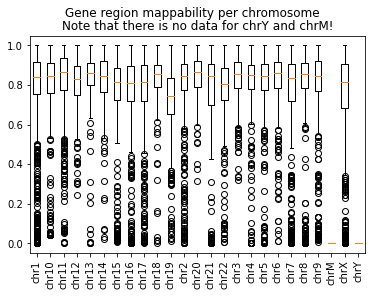

In [14]:
# calculate mean mappability per gene and plot 
mean_map=[[np.mean(g.get('mappability',[0])) for g in t.genes if g.chromosome==c] for c in t.merged_refdict]
_=plt.boxplot(mean_map)
_=plt.xticks([x+1 for x in range(len(t.merged_refdict))], list(t.merged_refdict.keys()), rotation=90)
_=plt.suptitle("Gene region mappability per chromosome")
_=plt.title("Note that there is no data for chrY and chrM!")

# Utility functions

_Pygenlib_ also contains a number of utility functions which might be useful for handling genomics data. Some of those functions are demonstrated in the following:

In [ ]:
# Gene symbols are updated regularly and mapping between different id schemas is cumbersome
# pygenlib implements an interface to MyGeneInfo for easy translation between ids and symbols 
# Example: we pass a mixed list of Ensembl and Entrez ids for mouse and human  actin beta:
geneid2symbol(['ENSMUSG00000029580', 60])

In [ ]:
# Here we use genenames.org data to convert lists containing partially old gene symbols to their current symbol
#gene_name_alias_file='/Users/niko.popitsch/Desktop/data/projects/Ameres/af2/colabfold_test/annotations/hgnc_complete_set.txt'
gene_name_alias_file='/groups/ameres/Niko/ref/genomes/GRCh38/annotation/20230206_hgnc_complete_set.txt'

aliases, current_symbols = read_alias_file(gene_name_alias_file)
# now lets translate some previous names of AADAC
norm_gn('DAC', current_symbols, aliases), norm_gn('CES5A1', current_symbols, aliases)

In [ ]:
# We also provide a wrapper around some useful Biopython methods, e.g., for sequence alignment
refseq='AAATTTCCCACTGAAATTTCCC'
score, startpos, endpos = align_sequence('ACTGactTTTC', refseq, print_alignment=True)
print(f"We found a match from {startpos}-{endpos} ('{'AAATTTCCCACTGAAATTTCCC'[startpos:endpos]}') with normalized alignment score {score}")

In [ ]:
# And utilities to work with Nanopore data (FAST5 files)
# You can, e.g., inspect the structure of such a file:
fast5_file='/groups/ameres/Niko/projects/Ameres/nanopore/data/NA12878_HG001/0_fast5/Bham_Run1/Bham_Run1.batch0_0.fast5' # testdata/FAT61995_a1291c8f_5.fast5
print_fast5_tree(fast5_file, show_attrs=False)

In [ ]:
# Or check the basecalling groups in this file
fast5_file='/groups/ameres/Niko/projects/Ameres/nanopore/data/nanocall_gfp/results/basecalled/wt/FAQ55498_b5ea166b_0.fast5'
get_bcgs(fast5_file)